#### output weights 2 layer, threads, validation set, graph plot, test set, lstm cell stack

In [1]:
from sklearn import metrics
import tensorflow as tf
import csv
from threading import Thread
from matplotlib import pyplot as plt
from  read_proces_data import *

In [2]:
sess = tf.InteractiveSession()

In [3]:
# create lstm cell in tensorflow
hidden_units = 512
num_layers = 3
def lstm_cell():
    return tf.contrib.rnn.BasicLSTMCell(num_units =\
        hidden_units,state_is_tuple=True)
stacked_cell = tf.contrib.rnn.MultiRNNCell(\
        [lstm_cell() for _ in range(num_layers)], \
        state_is_tuple=True)

In [4]:
batch_size = 20
max_seq = 3260
feature_vec_len = 57
x = tf.placeholder(tf.float32, shape = [batch_size,max_seq,feature_vec_len])
s_len = tf.placeholder(tf.int32,shape=[batch_size])
# run lstm over different sequence length
output_, state = tf.nn.dynamic_rnn(\
        stacked_cell,\
        x,\
#        initial_state = i_state,\
        sequence_length=s_len,\
        dtype=tf.float32)
# take all batch, last output of each batch and full output vector
def take_subarray(array , index):
    return array[range(0,batch_size),index-1]
output = tf.py_func(take_subarray,[output_,s_len],tf.float32)
#print output
# define final output value
target_value = tf.placeholder(tf.float32, shape=[batch_size])
# define weights and bias from output of lstm cell to network final output
output_size = stacked_cell.output_size

rv1 = tf.truncated_normal([output_size, 2 * output_size],\
        stddev=0.1,dtype=tf.float32)
Wo1 = tf.Variable(rv1,dtype=tf.float32)

rv2 = tf.truncated_normal([2 * output_size, 2 * output_size],\
        stddev=0.1,dtype=tf.float32)
Wo2 = tf.Variable(rv2,dtype=tf.float32)

rv3 = tf.truncated_normal([2 * output_size, 1],\
        stddev=0.1,dtype=tf.float32)
Wo3 = tf.Variable(rv3,dtype=tf.float32)

rb1 = tf.constant(0.1,shape=[2 * output_size],dtype=tf.float32)
b1 = tf.Variable(rb1,dtype=tf.float32)

rb2 = tf.constant(0.1,shape=[2 * output_size],dtype=tf.float32)
b2 = tf.Variable(rb2,dtype=tf.float32)

rb3 = tf.constant(0.1,shape=[1],dtype=tf.float32)
b3 = tf.Variable(rb3,dtype=tf.float32)
# initialize variables
# calculate final output

s1  = tf.matmul(output, Wo1) + b1
o1 = tf.nn.relu(s1)

s2  = tf.matmul(o1, Wo2) + b2
o2 = tf.nn.relu(s2)

logits  = tf.matmul(o2, Wo3) + b3
observed = tf.sigmoid(logits)
#observed = tf.nn.relu(logits)

# calculate cost as calculated in logistic classification.
logistic_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
        labels = tf.reshape(target_value,[batch_size,1]), logits = logits))
#cost = tf.reduce_mean(-1.0 * target_value * tf.log(observed) - \
#        (1 - target_value) * tf.log(1 - observed))
#cost = tf.reduce_mean(-1 * target_value * tf.log(observed))
#cost = tf.reduce_mean(tf.square(target_value - observed))
# optimize the cost
train_step = tf.train.AdamOptimizer(1e-4).minimize(logistic_cost)
def threshold_fn(array):
    return array >= 0.50
obser = tf.py_func(threshold_fn,[observed], tf.bool)
observe = tf.cast(obser,tf.float32)

sess.run(tf.global_variables_initializer())

In [5]:
# find max no of times to roll back
#max_seq_len = find_max_seq_len()
#print max_seq_len
max_seq_len = 3259

In [6]:
inde_featuress = []
sseq_len = []
target_valuess = []
def data_processing(file_name):
    # get features from current indexed file
    features = get_train_data(file_name)
    # get target values corresponding to this file
    target_valuess.append(get_target_values(file_name))
    # training features is np array with max size and padding
    training_features, s_l = prepare_data(features, max_seq_len)
    sseq_len.append(s_l)
    # scale features to have 0 mean and 1 variance
    scaled_features = feature_scaling(training_features, batch_size,\
            s_l)
    # check if there is any NaN or Inf entries in data
    #isnan = np.any(np.isnan(scaled_features))
    #if True == isnan:
    #    print "nan entry found for file %s"%file_
    #isinf = np.any(np.isinf(scaled_features))
    #if True == isinf:
    #    print "inf entry found for file %s"%file_
    # find independent components from given features
    inde_featuress.append(independent_components(scaled_features, batch_size,\
            s_l))

In [7]:
def file_evaluate(data):
    # evaluate over whole file
    y = np.zeros(0)
    if "Sess05" in data[0]:
#                print file_
#                print inde_features.shape
        for index in range(0,100,batch_size):
#                    print inde_features[index:index+batch_size].shape                    
            #print inde_features.shape
            yfile = sess.run(observe, feed_dict = {\
                x:data[1][0][index:index+batch_size], \
                s_len:data[2][0][index:index+batch_size]})
            y = np.append(y,yfile)
    else:
        for index in range(0,60,batch_size):
            yfile = sess.run(observe, feed_dict = {\
                x:data[1][0][index:index+batch_size], \
                s_len:data[2][0][index:index+batch_size]})
            y = np.append(y,yfile)

    f1score = metrics.f1_score(data[3][0],y)
#    print "f1-score of file is %f"%f1score
    fprr, tprr, thresholds = metrics.roc_curve(data[3][0], y, pos_label=1)
    aucc = metrics.auc(fprr,tprr)
#    print "area under curve of file is %f"%aucc
    sk_acc = metrics.accuracy_score(data[3][0],y)
#    print "accuracy of file is %f"%sk_acc
#    print " "
    return (f1score, aucc, sk_acc)

In [8]:
def train_eval(train_data, val_data):
    max_iter = 2
    for i in range(0,max_iter):
        tr_fe, sl , tv =\
        sample_data(train_data[1][0],train_data[3][0],train_data[2][0],batch_size)

        sess.run(train_step, feed_dict = {target_value:tv,\
                x:tr_fe, s_len:sl})

        if i == max_iter-1:
            #print "iteration %d"%i
            print "cost %f"%sess.run(logistic_cost, feed_dict = {target_value:tv,\
                x:tr_fe, s_len:sl})

#            y = sess.run(observe, feed_dict = {x:tr_fe, s_len:sl})            
#            f1s = metrics.f1_score(tv,y)
#            print "f1-score is %f"%f1s
#            fpr, tpr, thresholds = metrics.roc_curve(tv, y, pos_label=1)
#            auc = metrics.auc(fpr,tpr)
#            print "area under curve is %f"%auc
#            sk_accuracy = metrics.accuracy_score(tv,y)
#            print "accuracy %f"%sk_accuracy
            # collect values to print graph later
            t_f1s, t_auc, t_acc = file_evaluate(train_data)
            train_para.append([t_f1s, t_auc, t_acc])
            # collect values to print graph later
            v_f1s, v_auc, v_acc = file_evaluate(val_data)
            vali_para.append([v_f1s, v_auc, v_acc])

In [ ]:
def plot_parameters(training_p, validation_p):
    nu_para = training_p.shape[1]
    para_name = ['f1score','auc','accuracy']
    for j in range(nu_para):
        plt.subplot(nu_para,1,j+1)
        plt.plot(training_p[:,j],'r')
        plt.plot(validation_p[:,j],'g')
        plt.ylabel(para_name[j])
        plt.grid()
    plt.show()

cost 0.705248


/home/gnl/TF/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


cost 0.708383
cost 0.691167
cost 0.701440
cost 0.698579
cost 0.704985
cost 0.697260
cost 0.695834


/home/gnl/TF/local/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


cost 0.691322
cost 0.694011
cost 0.694822
cost 0.691252
cost 0.688317
cost 0.692643
cost 0.692110
cost 0.692769
cost 0.694425
cost 0.693426
cost 0.695012
cost 0.693374
cost 0.693906
cost 0.694585
cost 0.694825
cost 0.692944
cost 0.695415
cost 0.693183
cost 0.692418
cost 0.694606
cost 0.693899
cost 0.693644
cost 0.691709
cost 0.697710
cost 0.694678
cost 0.694009
cost 0.690030
cost 0.693570
cost 0.691784
cost 0.692691
cost 0.695151
cost 0.693282
cost 0.692468
cost 0.693075
cost 0.689003
cost 0.693570
cost 0.691499
cost 0.693700
cost 0.692531
cost 0.693150
cost 0.691619
cost 0.690114
cost 0.687647
cost 0.693089
cost 0.691896
cost 0.698888
cost 0.696630
cost 0.700060
cost 0.686079
cost 0.698919
cost 0.689070
cost 0.693629
cost 0.692807
cost 0.688828
cost 0.692380
cost 0.689749
cost 0.694976
cost 0.693853
cost 0.694046
cost 0.688034
cost 0.696430
cost 0.691687
cost 0.699707
cost 0.696132
cost 0.691694
cost 0.691724
cost 0.695560
cost 0.694696
cost 0.691816
cost 0.693339
cost 0.694562


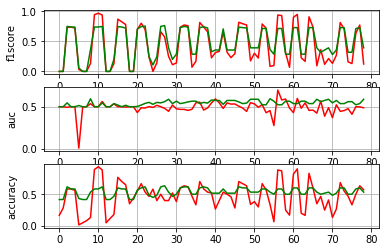

cost 0.697019
cost 0.692332
cost 0.696250
cost 0.696393
cost 0.694394
cost 0.685924
cost 0.689628
cost 0.696282
cost 0.698593
cost 0.693363
cost 0.689870
cost 0.692796
cost 0.687162
cost 0.693336
cost 0.694272
cost 0.693382
cost 0.690562
cost 0.699186
cost 0.691547
cost 0.694447
cost 0.695297
cost 0.692737
cost 0.690928
cost 0.694208
cost 0.696308
cost 0.691700
cost 0.690308
cost 0.691662
cost 0.694488
cost 0.693355
cost 0.697380
cost 0.689957
cost 0.693154
cost 0.695123
cost 0.692456
cost 0.693938
cost 0.690911
cost 0.688871
cost 0.691619
cost 0.689696
cost 0.693563
cost 0.691011
cost 0.691339
cost 0.695692
cost 0.694050
cost 0.691500
cost 0.694599
cost 0.692795
cost 0.695773
cost 0.696342
cost 0.693741
cost 0.689713
cost 0.696622
cost 0.693333
cost 0.696926
cost 0.680598
cost 0.696034
cost 0.701282
cost 0.693477
cost 0.691128
cost 0.693471
cost 0.695332
cost 0.691765
cost 0.689849
cost 0.693455


In [ ]:
# number of times to iterate over whole training dataset
check_1_time = 1
iter_over_files =  100
for itera in range(0, iter_over_files):
    dir_len = len(file_dir)
    # select file to treat as validation set
    val_file_no = np.random.randint(low=0,high=dir_len)
    val_file = file_dir[val_file_no]
    # train_para and vali_para are storing f1score,auc,accuracy for 
    # train and validation set.
    train_para = []
    vali_para = []
    
    data_thread = Thread(target=data_processing,args=(val_file,))
    data_thread.start()
    data_thread.join()
    # collect validation data in one list to reduce no of parameters
    # to pass between functions
    val_data = [val_file, inde_featuress, sseq_len, target_valuess]
    # reset these so that these can be used in the below call of data_processing
    inde_featuress = []
    sseq_len = []
    target_valuess = []
    # iterate over each file and train
    for file_ in file_dir:
        # do not train on validation file
        if file_ == val_file:
            continue
        data_thread = Thread(target=data_processing,args=(file_,))
        data_thread.start()
        data_thread.join()
        #print "reading data file %s"%file_
        # collect values to form a list to reduce the parameters to be passed
        train_data = [file_, inde_featuress, sseq_len, target_valuess]
        # reset the values to be used in next call of either val or train set
        inde_featuress = []
        sseq_len = []
        target_valuess = []
        
        if 1!=check_1_time:
            tr_ev_thread.join()
#        print thread_inde_features[0].shape
        tr_ev_thread = Thread(target = train_eval, args = \
            (train_data, val_data))
        tr_ev_thread.start()
        check_1_time = 0
        
    tr_ev_thread.join()
    
    t_para = np.asarray(train_para)
    v_para = np.asarray(vali_para)
    
    plot_parameters(t_para, v_para)

In [ ]:
plot_parameters(t_para, v_para)

In [ ]:
print ('opening file for write')
label = ["IdFeedBack,Prediction"]
with open('output.csv', 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ')
    spamwriter.writerow(label)

    for file_ in test_file_dir:
        # get features from current indexed file
        features = get_test_data(file_)        
        # training features is np array with max size and padding
        test_features, seq_len = prepare_data(features, max_seq_len)
        # scale features to have 0 mean and 1 variance
        scaled_features = feature_scaling(test_features, batch_size,\
                seq_len)
        # find independent components from given features
        inde_features = independent_components(scaled_features, batch_size,\
                seq_len)
        # evaluate over whole file
        y = np.zeros(0)
        if "Sess05" in file_:
            indices = ["%03d" %(i+1) for i in range(100)]
    #        print file_
            for index in range(0,100,batch_size):
                yfile = observe.eval(feed_dict = {\
                    x:inde_features[index:index+batch_size], \
                    s_len:seq_len[index:index+batch_size]})
                y = np.append(y,yfile)
        else:
            indices = ["%03d" %(i+1) for i in range(60)]
            for index in range(0,60,batch_size):
                yfile = observe.eval(feed_dict = {\
                    x:inde_features[index:index+batch_size], \
                    s_len:seq_len[index:index+batch_size]})
                y = np.append(y,yfile)

        for i in xrange(0,y.shape[0]):
            values = [file_[5:-4]+'_FB'+indices[i]+','+str(int(y[i]))]
            spamwriter.writerow(values)
print ('file write complete')